In [52]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
from datetime import datetime

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier

from keras import regularizers

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras.datasets import mnist
from keras.models import Sequential
import tensorflow as tf

from sklearn import ensemble, preprocessing


from sklearn.model_selection import train_test_split
%matplotlib inline

In [53]:
from geopy import distance

# functions to weight weather measurements based on distance from source

def Ohare_Weather_Weight(df):
    midway = (41.786, -87.752)
    ohare = (41.995, -87.933)
    ohare_distance = [distance.distance(x, ohare).km for x in zip(df['Latitude'], df['Longitude'])]
    midway_distance = [distance.distance(x, midway).km for x in zip(df['Latitude'], df['Longitude'])]
    Ohare_Weight = [1-(x/(x+y)) for x, y in zip(ohare_distance, midway_distance)]
    return(Ohare_Weight)
    
def Midway_Weather_Weight(df):
    Midway_Weight =  [1 - x for x in Ohare_Weather_Weight(df)]
    return Midway_Weight

In [54]:
def date_conversions(df):
    
    '''
    Will take the 'Date' feature of dataframe df and return a dataframe with two extra feature cols:
    
    'day_of_year' & 'week_of_year'  & 'year'
    
    Function assumes 'Date' is in 'YYYY-MM-DD' format    
    '''
    
    day_of_year = []
    week_of_year = []
    years = []
    
    
    for x in df.index: #Will parse the string in 'Date' and then reformat to the attributes we want
        datetime_object = datetime.strptime(df['Date'][x], '%Y-%m-%d')
        day_of_year.append(datetime_object.strftime('%j'))
        week_of_year.append(datetime_object.strftime('%U'))
        years.append(datetime_object.strftime('%Y'))
        
        
    df['day_of_year'] = day_of_year
    df['week_of_year'] = week_of_year
    df['year'] = years
    
    return df

In [55]:
def weather_features(weather):
    
    """
    Takes in a dataframe and returns it with appended weather features,
    Unions on 'Date' Column
       
    """
#     max_temp_7 = []
#     max_temp_two_weeks_ago = []
#     avg_temp_two_weeks = []
#     min_temp_two_weeks = []
#     wet_bulb = []
#     tot_precip_70 = []

#     for x in df['Date']:

#         max_temp_7.append(weather['Tmax'].rolling(window= 14).max()[weather[weather['Date'] == x].index[1]])
#         max_temp_two_weeks_ago.append(weather['Tmax'].shift(14).rolling(window= 14).max()[weather[weather['Date'] == x].index[1]])
#         avg_temp_two_weeks.append(weather['Tavg'].rolling(window= 28).mean()[weather[weather['Date'] == x].index[1]])
#         wet_bulb.append(weather['WetBulb'].rolling(window= 28).mean()[weather[weather['Date'] == x].index[1]])
#         min_temp_two_weeks.append(weather['Tmin'].rolling(window= 28).min()[weather[weather['Date'] == x].index[1]])
#         #tot_precip_70.append((weather['PrecipTotal'].rolling(window= 140).sum()[weather[weather['Date'] == x].index[1]])/2)

#     df['max_temp_7'] = max_temp_7
#     df['max_temp_two_weeks_ago'] = max_temp_two_weeks_ago
#     df['avg_temp_two_weeks'] = avg_temp_two_weeks
#     df['min_temp_two_weeks'] = min_temp_two_weeks
#     df['wet_bulb'] = wet_bulb
#     df['tot_precip_70'] = tot_precip_70
#     tot_pre_mean = df['tot_precip_70'].mean()
#     df['tot_precip_70'].fillna(value = tot_pre_mean, inplace =True)

    # Split station 1 and 2 and join horizontally
    weather_stn1 = weather[weather['Station']==1]
    weather_stn2 = weather[weather['Station']==2]
    weather_stn1 = weather_stn1.drop('Station', axis=1)
    weather_stn2 = weather_stn2.drop('Station', axis=1)
    weather = weather_stn1.merge(weather_stn2, on='Date')
    
    
    
    return weather

In [56]:
# Count how many duplicate rows based off of Date Trap and Species
def duplicate_col_feature(df):
    '''
    Takes in df and returns it with feature col 'num_dupes'
    that records how many duplicate columns there are
    
    '''
    num_dupes = df.groupby(['Date','Trap','Species']).count().year.to_dict()

    df['num_dupes'] = -999
    for index in df.index:
        date = df.loc[index,'Date']
        trap = df.loc[index, 'Trap']
        species = df.loc[index, 'Species']
        df.loc[index, 'num_dupes'] = num_dupes[(date,trap,species)]
        
    return df


In [220]:
def weather_eda(weather):
    
    #Kills nulls in weather df
    
    weather.drop(columns = ['Water1'], inplace=True)  # Dropping as all the values are 'M'

    weather.loc[weather['Station'] == 2] = weather.loc[weather['Station'] == 2].replace('M', np.nan).copy()
    #replace "M" with nan where station = 2 
    weather.fillna(method='ffill', inplace=True) # Fills nan with the values in the row above

    weather[weather['Station'] == 1] = weather[weather['Station'] == 1].replace('M', np.nan).copy() #replace "M" with nan where station = 1
    weather.fillna(method='bfill', inplace=True) # Fills nan with the values in the row below 

    #replaceing T with 0.01  in 'PrecipTotal' when RA is present
    weather['PrecipTotal'].loc[weather['CodeSum'].str.contains('RA')] = \
    weather['PrecipTotal'].loc[weather['CodeSum'].str.contains('RA')].replace('  T', 0.01)

    #replacing T  with 0.00 in 'PrecipTotal' when RA is not present
    weather['PrecipTotal'].replace('  T', 0.00, inplace=True)
    
    return weather

def alter_df(train, test, weather):
    
    """
    Enter freshly imported dataframes and get dataframes ready for testing
    
    Returns: 
    
    X_train, X_holdout, y_train, y_holdout, test
    
    """
    
    weather = weather_eda(weather)
    weather = weather_features(weather)
    # replace some missing values and T with -1
    weather = weather.replace('M', -1)
    weather = weather.replace('-', -1)
    weather = weather.replace('T', -1)
    weather = weather.replace(' T', -1)
    weather = weather.replace('  T', -1)
    
    train = train.merge(weather, on='Date')
    test = test.merge(weather, on='Date')
    print('1')
    train = date_conversions(train)
    test = date_conversions(test)
    print('2')
    train = duplicate_col_feature(train)
    test = duplicate_col_feature(test)
    print('3')
    dummy = ['Species', 'Block', 'Trap']
    drop_cols = ['Date', 'Address', 'Street', 'AddressNumberAndStreet', 'NumMosquitos','WnvPresent']
    drop_test = ['Date', 'Address', 'Street', 'AddressNumberAndStreet']
    
    train = train[train['Species'] != 'CULEX TERRITANS'].copy()  # DROP ROWS WITH INCONSEQUENTIAL SPECIES
    train = train[train['Species'] != 'CULEX SALINARIUS'].copy()
    train = train[train['Species'] != 'CULEX TARSALIS'].copy()
    train = train[train['Species'] != 'CULEX ERRATICUS'].copy()
    

    
    y = train['WnvPresent']
    
    
    
    X = train.drop(labels=drop_cols, axis=1).copy()
    X = pd.get_dummies(X, columns=dummy).copy()
    test = pd.get_dummies(test, columns=dummy).copy()
    
    print('4')
    test = test.drop(labels=drop_test, axis=1).copy()
    test.drop(labels = ['CodeSum_x','CodeSum_y'], axis=1, inplace=True)
    X.drop(labels = ['CodeSum_x','CodeSum_y'], axis=1, inplace=True)
    
    for x in test.select_dtypes(include=object).columns:
        test[x] = pd.to_numeric(test[x])
    
    for x in X.select_dtypes(include=object).columns:
        X[x] = pd.to_numeric(X[x])
        
    print('5')
    X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.3, random_state=666)
    
    drop_test_set = [x for x in set(test.columns)-set(X_train.columns)]
    test = test.drop(labels=drop_test_set, axis=1).copy()
    
    
    return X_train, X_holdout, y_train, y_holdout, test

# IMPORTS BELOW, Start here for that fresh febreeze start

In [221]:
train = pd.read_csv('Data/train.csv')
test = pd.read_csv('Data/test.csv')
weather = pd.read_csv('Data/weather.csv')
spray = pd.read_csv('Data/spray.csv')

In [252]:
spray.head()

,Date,Time,Latitude,Longitude
0,2011-08-29,6:56:58 PM,42.391623,-88.089163
1,2011-08-29,6:57:08 PM,42.391348,-88.089163
2,2011-08-29,6:57:18 PM,42.391022,-88.089157
3,2011-08-29,6:57:28 PM,42.390637,-88.089158
4,2011-08-29,6:57:38 PM,42.390410,-88.088858


In [259]:
#Group all dataframes by year, this can be done by masking on the year column from date_conversion as well
# Mostly for EDA stuff

train_07 = train[train['Date'].apply(lambda x: x[0:4]) == '2007'].copy()
train_09 = train[train['Date'].apply(lambda x: x[0:4]) == '2009'].copy()
train_11 = train[train['Date'].apply(lambda x: x[0:4]) == '2011'].copy()
train_13 = train[train['Date'].apply(lambda x: x[0:4]) == '2013'].copy()

test_08 = train[train['Date'].apply(lambda x: x[0:4]) == '2008'].copy()
test_10 = train[train['Date'].apply(lambda x: x[0:4]) == '2010'].copy()
test_12 = train[train['Date'].apply(lambda x: x[0:4]) == '2012'].copy()
test_14 = train[train['Date'].apply(lambda x: x[0:4]) == '2014'].copy()

In [223]:
%%time

X_train, X_holdout, y_train, y_holdout, test = alter_df(train, test, weather)

C:\Users\Johnny\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


1
2
3
4
5
Wall time: 8min 9s


In [225]:
%%time
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)
print(tree.score(X_holdout,y_holdout))

0.9254414650098103
Wall time: 111 ms


In [226]:
%%time
bag = BaggingClassifier(random_state=666)
bag_params = {
    'n_estimators': range(10,21)
    
    
}

gs_bc = GridSearchCV(bag, param_grid=bag_params, verbose=2,n_jobs=-1)
gs_bc.fit(X_train, y_train)
print(gs_bc.best_score_)
print(gs_bc.best_params_)

Fitting 3 folds for each of 11 candidates, totalling 33 fits


[Parallel(n_jobs=-1)]: Done  27 out of  33 | elapsed:   11.2s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done  33 out of  33 | elapsed:   11.6s finished


0.931585588111594
{'n_estimators': 14}
Wall time: 13.1 s


In [227]:
%%time
lr = LogisticRegression()
lr.fit(X_train, y_train)
print(lr.score(X_holdout, y_holdout))

0.9499672988881622
Wall time: 280 ms


In [290]:
lr.get_params

<bound method BaseEstimator.get_params of LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)>

In [228]:
# X = pd.concat(objs=[X_train,X_holdout],axis = 0)
# y = pd.concat(objs=[y_train,y_holdout],axis = 0)
# y

In [285]:
rf = RandomForestClassifier()

rf_params = {
    'n_estimators': [10,50],
    'max_features': [5,10,30],
    'max_depth': [2,3,4]
    
}
gs = GridSearchCV(rf, param_grid=rf_params, verbose=1,n_jobs=-1, cv=5)
gs.fit(X_train,y_train)
gs.score(X_holdout,y_holdout)
print(gs.best_score_)
print(gs.best_params_)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    4.9s


0.9442030001401934
{'max_depth': 2, 'max_features': 5, 'n_estimators': 10}


[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    6.3s finished


In [233]:
et = ExtraTreesClassifier()

et_params = {
       
}

gs = GridSearchCV(et, param_grid=et_params, n_jobs=-1)
gs.fit(X_train, y_train)
gs.score(X_holdout,y_holdout)

0.9391759319816874

In [163]:
sample = pd.read_csv('Data/sampleSubmission.csv')
submission = sample.copy()

In [245]:
predictions = gs.predict_proba(test)[:,1]
#predictions = [1 if x > 0.5 else 0 for x in predictions]
submission['WnvPresent'] = predictions
submission.to_csv('hope_i_score_rand_for.csv', index=False)

predictions = gs.predict_proba(test)[:,1]
#predictions = [1 if x > 0.5 else 0 for x in predictions]
submission['WnvPresent'] = predictions
submission.to_csv('hope_i_score_ET.csv', index=False)

predictions = lr.predict_proba(test)[:,1]
#predictions = [1 if x > 0.5 else 0 for x in predictions]
submission['WnvPresent'] = predictions
submission.to_csv('hope_i_score_log.csv', index=False)

predictions = gs_bc.predict_proba(test)[:,1]
#predictions = [1 if x > 0.5 else 0 for x in predictions]
submission['WnvPresent'] = predictions
submission.to_csv('hope_i_score_bag_class.csv', index=False)



In [231]:
# submission['WnvPresent'] = 1 - submission["WnvPresent"]

# submission.to_csv('hope_i_score_OK_inverse.csv', index=False)

In [236]:
submission['WnvPresent'].head()

4172.74660022132

In [249]:
weather.columns.shape

(21,)

# Mostly EDA and Visualizations below here

In [63]:
train['WnvPresent'].sum() # With only 5% true in target vector a form of oversampling might be necessary

551

In [136]:
weather.head(2)

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,...,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,day_of_year,week_of_year,year
0,1,2007-05-01,83,50,67,14,51,56,0,2,...,0.0,0.00,29.10,29.82,1.7,27,9.2,121,17,2007
1,2,2007-05-01,84,52,68,M,51,57,0,3,...,M,0.00,29.18,29.82,2.7,25,9.6,121,17,2007


In [65]:
weather.columns

Index(['Station', 'Date', 'Tmax', 'Tmin', 'Tavg', 'Depart', 'DewPoint',
       'WetBulb', 'Heat', 'Cool', 'Sunrise', 'Sunset', 'CodeSum', 'Depth',
       'Water1', 'SnowFall', 'PrecipTotal', 'StnPressure', 'SeaLevel',
       'ResultSpeed', 'ResultDir', 'AvgSpeed', 'day_of_year', 'week_of_year',
       'year'],
      dtype='object')

In [66]:
weather.describe().T

,count,mean,std,min,25%,50%,75%,max
Station,2944.0,1.500000,0.500085,1.0,1.0,1.5,2.0,2.0
Tmax,2944.0,76.166101,11.461970,41.0,69.0,78.0,85.0,104.0
Tmin,2944.0,57.810462,10.381939,29.0,50.0,59.0,66.0,83.0
DewPoint,2944.0,53.457880,10.675181,22.0,46.0,54.0,62.0,75.0
ResultSpeed,2944.0,6.960666,3.587527,0.1,4.3,6.4,9.2,24.1
ResultDir,2944.0,17.494905,10.063609,1.0,7.0,19.0,25.0,36.0


In [13]:
spray.head()

,Date,Time,Latitude,Longitude
0,2011-08-29,6:56:58 PM,42.391623,-88.089163
1,2011-08-29,6:57:08 PM,42.391348,-88.089163
2,2011-08-29,6:57:18 PM,42.391022,-88.089157
3,2011-08-29,6:57:28 PM,42.390637,-88.089158
4,2011-08-29,6:57:38 PM,42.390410,-88.088858


In [14]:
spray.describe()

,Latitude,Longitude
count,14835.000000,14835.000000
mean,41.904828,-87.736690
std,0.104381,0.067292
min,41.713925,-88.096468
25%,41.785001,-87.794225
50%,41.940075,-87.727853
75%,41.980978,-87.694108
max,42.395983,-87.586727


# DataFrames grouped by year EDA

In [55]:
print('2007 num mosquitos:',train_07['NumMosquitos'].sum(), 'WNV Count', train_07['WnvPresent'].sum())
print('2009 num mosquitos:',train_09['NumMosquitos'].sum(),'WNV Count', train_09['WnvPresent'].sum())
print('2011 num mosquitos:',train_11['NumMosquitos'].sum(),'WNV Count', train_11['WnvPresent'].sum())
print('2013 num mosquitos:',train_13['NumMosquitos'].sum(),'WNV Count', train_13['WnvPresent'].sum())

2007 num mosquitos: 58688 WNV Count 236
2009 num mosquitos: 21108 WNV Count 19
2011 num mosquitos: 18799 WNV Count 57
2013 num mosquitos: 36444 WNV Count 239


In [20]:
train_09[train_09['NumMosquitos']==50].groupby('Trap').sum()

,Block,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
Trap,,,,,,
T002,328,335.637520,-702.407928,72,400,1
T008,210,126.024942,-263.333763,27,150,0
T009,273,125.977434,-263.588985,24,150,0
T011,36,41.944869,-87.832763,8,50,0
T016,72,42.011601,-87.811506,8,50,0
T031,150,125.404494,-263.290248,27,150,0
T048,11,41.867108,-87.654224,8,50,0
T066,67,41.771660,-87.703047,8,50,0
T115,60,208.367040,-437.999310,25,250,0


In [56]:
train.groupby(['week_of_year','Trap','Species']).sum()

Block    Latitude   Longitude  \
week_of_year Trap Species                                                 
21           T002 CULEX PIPIENS/RESTUANS     82   83.909380 -175.601982   
                  CULEX RESTUANS             41   41.954690  -87.800991   
             T003 CULEX PIPIENS/RESTUANS     46   41.964242  -87.757639   
             T007 CULEX RESTUANS             62   41.994991  -87.769279   
             T008 CULEX PIPIENS/RESTUANS    140   84.016628 -175.555842   
             T009 CULEX RESTUANS             91   41.992478  -87.862995   
             T011 CULEX PIPIENS/RESTUANS     36   41.944869  -87.832763   
             T012 CULEX PIPIENS/RESTUANS     61   41.991429  -87.747113   
                  CULEX RESTUANS             61   41.991429  -87.747113   
             T015 CULEX PIPIENS/RESTUANS     79   41.974089  -87.824812   
                  CULEX RESTUANS             79   41.974089  -87.824812   
             T017 CULEX RESTUANS             60   41.960616  -87.777189   
             T028 CULEX PIPIENS/RESTUANS     58   41.986921  -87.689778   
             T030 CULEX PIPIENS/RESTUANS     10   41.899230  -87.716788   
             T031 CULEX PIPIENS/RESTUANS     50   41.801498  -87.763416   
                  CULEX RESTUANS             50   41.801498  -87.763416   
             T039 CULEX RESTUANS             17   41.911824  -87.726737   
             T043 CULEX PIPIENS/RESTUANS     30   41.857402  -87.694991   
             T045 CULEX PIPIENS/RESTUANS     15   41.921600  -87.666455   
                  CULEX RESTUANS             15   41.921600  -87.666455   
             T046 CULEX RESTUANS             25   41.891118  -87.654491   
             T048 CULEX PIPIENS/RESTUANS     11   41.867108  -87.654224   
                  CULEX RESTUANS             11   41.867108  -87.654224   
             T049 CULEX RESTUANS             11   41.896282  -87.655232   
             T050 CULEX PIPIENS/RESTUANS     21   41.919343  -87.694259   
             T054 CULEX PIPIENS/RESTUANS     44   83.843930 -175.264170   
                  CULEX RESTUANS             44   83.843930 -175.264170   
             T062 CULEX PIPIENS/RESTUANS     35   41.800737  -87.711880   
             T063 CULEX PIPIENS/RESTUANS     37   41.825610  -87.726549   
             T073 CULEX PIPIENS/RESTUANS     10   41.773215  -87.600880   
...                                         ...         ...         ...   
39           T231 CULEX PIPIENS/RESTUANS     58   41.987280  -87.666066   
             T232 CULEX RESTUANS             17   41.912563  -87.668055   
             T233 CULEX PIPIENS/RESTUANS     71   42.009876  -87.807277   
                  CULEX RESTUANS             71   42.009876  -87.807277   
             T900 CULEX PIPIENS              20   83.949378 -175.781230   
                  CULEX PIPIENS/RESTUANS     80  335.797512 -703.124920   
                  CULEX RESTUANS             40  167.898756 -351.562460   
             T903 CULEX PIPIENS              10   41.957799  -87.930995   
                  CULEX PIPIENS/RESTUANS     30  125.873397 -263.792985   
                  CULEX RESTUANS             20   83.915598 -175.861990   
40           T027 CULEX PIPIENS/RESTUANS     58   41.984809  -87.728492   
             T107 CULEX PIPIENS              81   41.729669  -87.582699   
                  CULEX PIPIENS/RESTUANS     81   41.729669  -87.582699   
             T115 CULEX PIPIENS              36  125.020224 -262.799586   
                  CULEX PIPIENS/RESTUANS     24   83.346816 -175.199724   
             T128 CULEX PIPIENS              24   41.704572  -87.565666   
                  CULEX PIPIENS/RESTUANS     24   41.704572  -87.565666   
             T138 CULEX PIPIENS              10   41.726465  -87.585413   
                  CULEX PIPIENS/RESTUANS     20   83.452930 -175.170826   
             T200 CULEX PIPIENS              26   83.357236 -175.118616   
                  CULEX PIPIENS/RESTUANS     26   83.357236 -175.11

In [53]:
train[train.duplicated(subset=['Date','Address','Species'], keep=False)]


,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,day_of_year,week_of_year,year
98,2007-06-26,"2200 West 113th Street, Chicago, IL 60643, USA",CULEX PIPIENS/RESTUANS,22,W 113TH ST,T086,"2200 W 113TH ST, Chicago, IL",41.688324,-87.676709,8,1,0,177,25,2007
99,2007-06-26,"2200 West 113th Street, Chicago, IL 60643, USA",CULEX PIPIENS/RESTUANS,22,W 113TH ST,T086,"2200 W 113TH ST, Chicago, IL",41.688324,-87.676709,8,1,0,177,25,2007
280,2007-07-11,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0,192,27,2007
281,2007-07-11,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,2,0,192,27,2007
293,2007-07-11,"2200 West 113th Street, Chicago, IL 60643, USA",CULEX PIPIENS/RESTUANS,22,W 113TH ST,T086,"2200 W 113TH ST, Chicago, IL",41.688324,-87.676709,8,50,0,192,27,2007
294,2007-07-11,"2200 West 113th Street, Chicago, IL 60643, USA",CULEX PIPIENS/RESTUANS,22,W 113TH ST,T086,"2200 W 113TH ST, Chicago, IL",41.688324,-87.676709,8,35,0,192,27,2007
295,2007-07-11,"2200 West 113th Street, Chicago, IL 60643, USA",CULEX PIPIENS/RESTUANS,22,W 113TH ST,T086,"2200 W 113TH ST, Chicago, IL",41.688324,-87.676709,8,50,0,192,27,2007
296,2007-07-11,"2200 West 113th Street, Chicago, IL 60643, USA",CULEX PIPIENS/RESTUANS,22,W 113TH ST,T086,"2200 W 113TH ST, Chicago, IL",41.688324,-87.676709,8,8,0,192,27,2007
297,2007-07-11,"2200 West 113th Street, Chicago, IL 60643, USA",CULEX RESTUANS,22,W 113TH ST,T086,"2200 W 113TH ST, Chicago, IL",41.688324,-87.676709,8,1,0,192,27,2007
298,2007-07-11,"2200 West 113th Street, Chicago, IL 60643, USA",CULEX RESTUANS,22,W 113TH ST,T086,"2200 W 113TH ST, Chicago, IL",41.688324,-87.676709,8,8,0,192,27,2007


In [15]:
train['Species'].value_counts()

CULEX PIPIENS/RESTUANS    4752
CULEX RESTUANS            2740
CULEX PIPIENS             2699
CULEX TERRITANS            222
CULEX SALINARIUS            86
CULEX TARSALIS               6
CULEX ERRATICUS              1
Name: Species, dtype: int64

In [16]:
train.groupby('Species')['WnvPresent'].mean()

Species
CULEX ERRATICUS           0.000000
CULEX PIPIENS             0.088922
CULEX PIPIENS/RESTUANS    0.055135
CULEX RESTUANS            0.017883
CULEX SALINARIUS          0.000000
CULEX TARSALIS            0.000000
CULEX TERRITANS           0.000000
Name: WnvPresent, dtype: float64

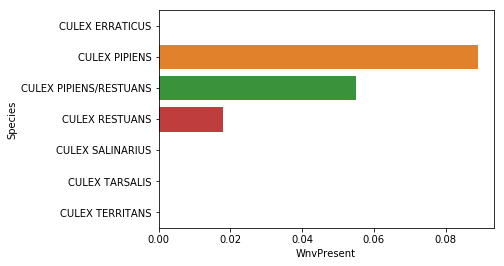

In [17]:
sns.barplot(x = train.groupby('Species')['WnvPresent'].mean(), y =train.groupby('Species')['WnvPresent'].mean().index)

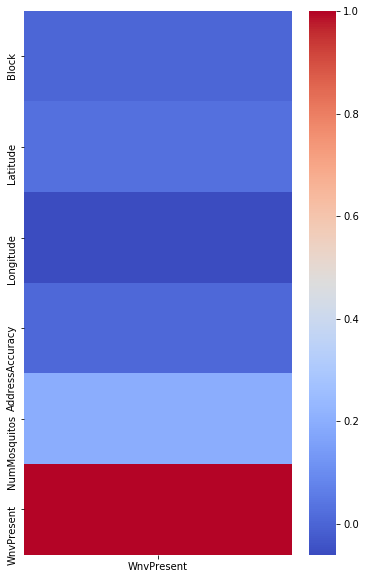

In [240]:
plt.figure(figsize = (6,10))
sns.heatmap(pd.DataFrame(train.corr()['WnvPresent']), cmap='coolwarm')


In [257]:
train = date_conversions(train)
train.head()

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,day_of_year,week_of_year,year
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0,149,21,2007
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0,149,21,2007
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0,149,21,2007
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0,149,21,2007
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0,149,21,2007


Text(0.5,1,'2013')

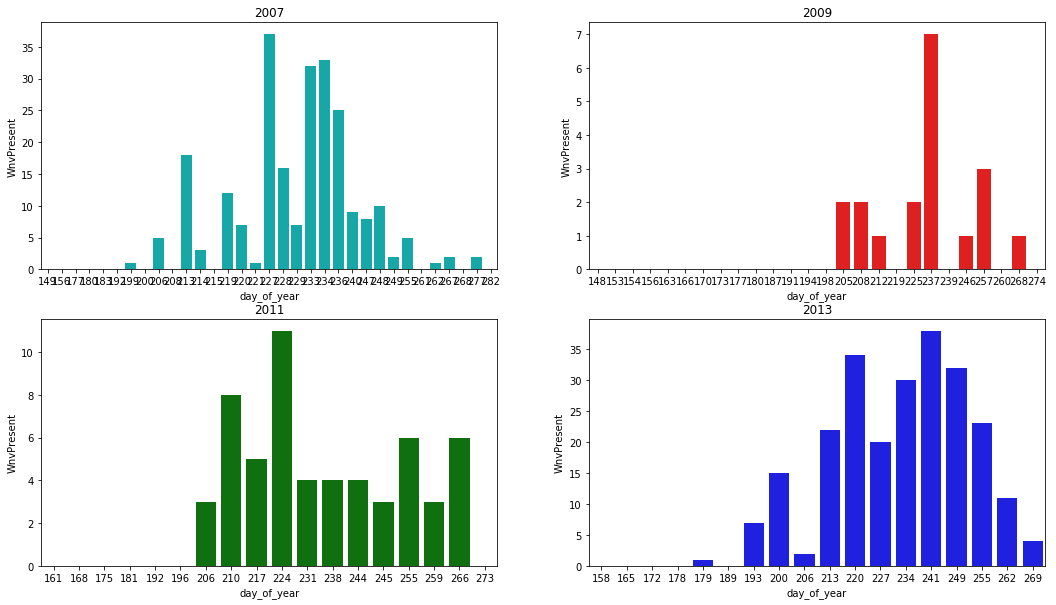

In [279]:
fig, ax = plt.subplots(nrows=2,ncols=2, figsize = (18,10))

sns.barplot(
            x = train_07.groupby('day_of_year').sum().index,
            y = train_07.groupby('day_of_year').sum()['WnvPresent'],
            color= 'c',
            ax = ax[0,0]
           )
ax[0,0].set_title('2007')

sns.barplot(
            x = train_09.groupby('day_of_year').sum().index,
            y = train_09.groupby('day_of_year').sum()['WnvPresent'],
            color= 'r',
            ax = ax[0,1]
           )
ax[0,1].set_title('2009')

sns.barplot(
            x = train_11.groupby('day_of_year').sum().index,
            y = train_11.groupby('day_of_year').sum()['WnvPresent'],
            color= 'g',
            ax = ax[1,0]
           )
ax[1,0].set_title('2011')

sns.barplot(
            x = train_13.groupby('day_of_year').sum().index,
            y = train_13.groupby('day_of_year').sum()['WnvPresent'],
            color= 'b',
            ax = ax[1,1]
           )
ax[1,1].set_title('2013')

Text(0.5,1,'2013')

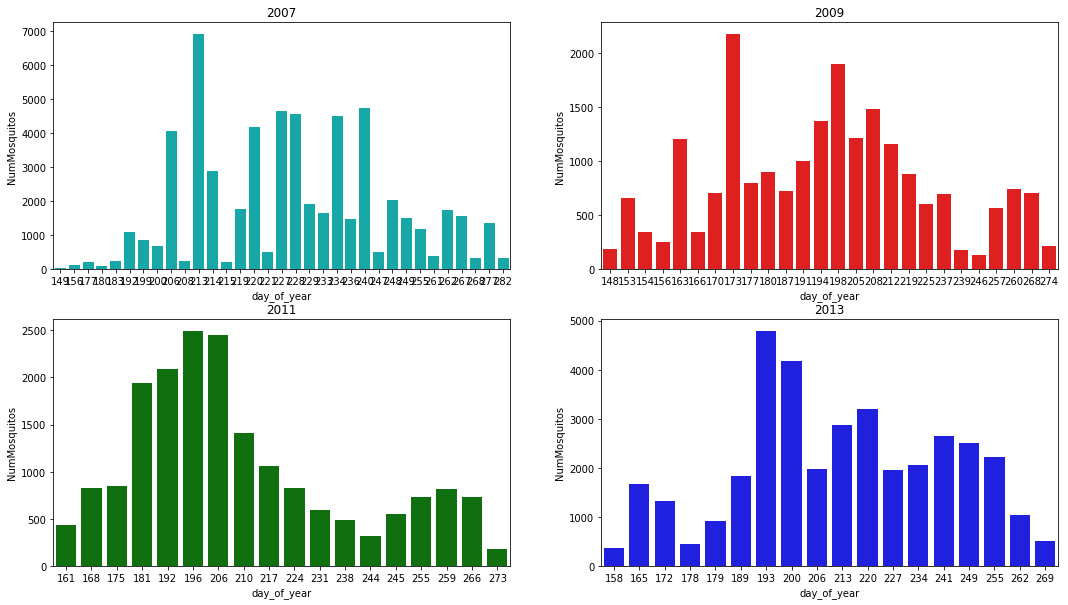

In [281]:
fig, ax = plt.subplots(nrows=2,ncols=2, figsize = (18,10), sharex=False)
ax

sns.barplot(
            x = train_07.groupby('day_of_year').sum().index,
            y = train_07.groupby('day_of_year').sum()['NumMosquitos'],
            color= 'c',
            ax = ax[0,0]
           )
ax[0,0].set_title('2007')

sns.barplot(
            x = train_09.groupby('day_of_year').sum().index,
            y = train_09.groupby('day_of_year').sum()['NumMosquitos'],
            color= 'r',
            ax = ax[0,1]
           )
ax[0,1].set_title('2009')

sns.barplot(
            x = train_11.groupby('day_of_year').sum().index,
            y = train_11.groupby('day_of_year').sum()['NumMosquitos'],
            color= 'g',
            ax = ax[1,0]
           )
ax[1,0].set_title('2011')

sns.barplot(
            x = train_13.groupby('day_of_year').sum().index,
            y = train_13.groupby('day_of_year').sum()['NumMosquitos'],
            color= 'b',
            ax = ax[1,1]
           )
ax[1,1].set_title('2013')

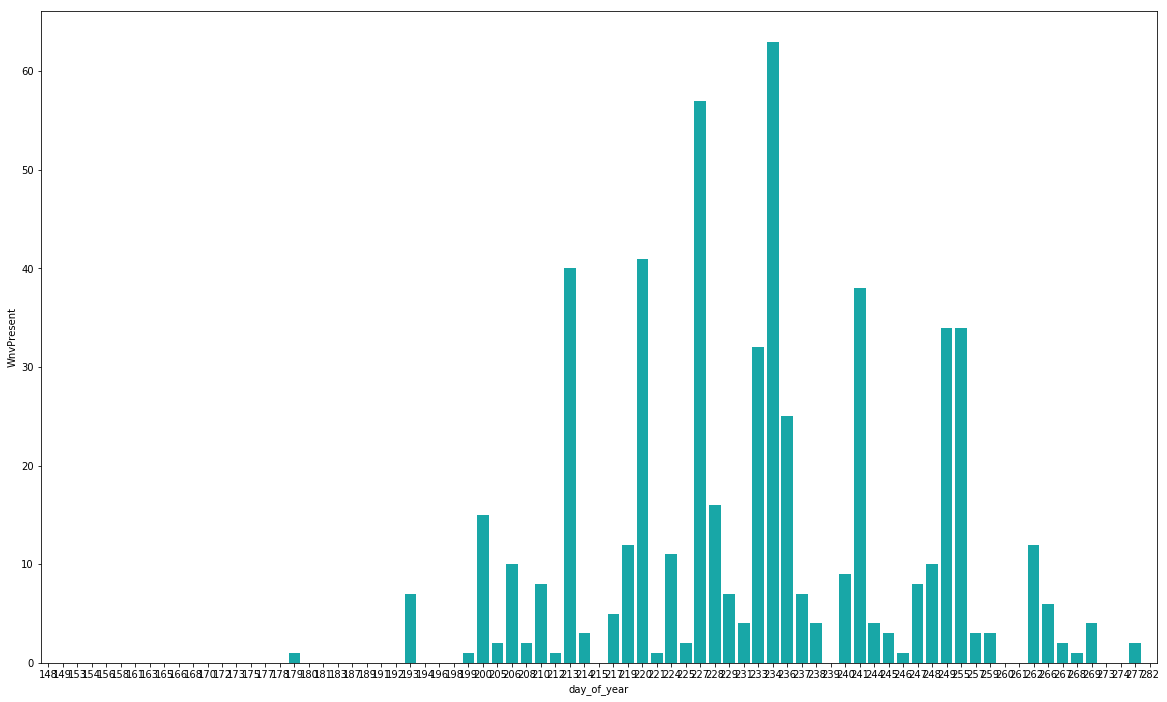

In [101]:
fig  = plt.figure(figsize=(20,12))
sns.barplot(
            x = train.groupby('day_of_year').sum().index,
            y = train.groupby('day_of_year').sum()['WnvPresent'],
            color= 'c'
           )

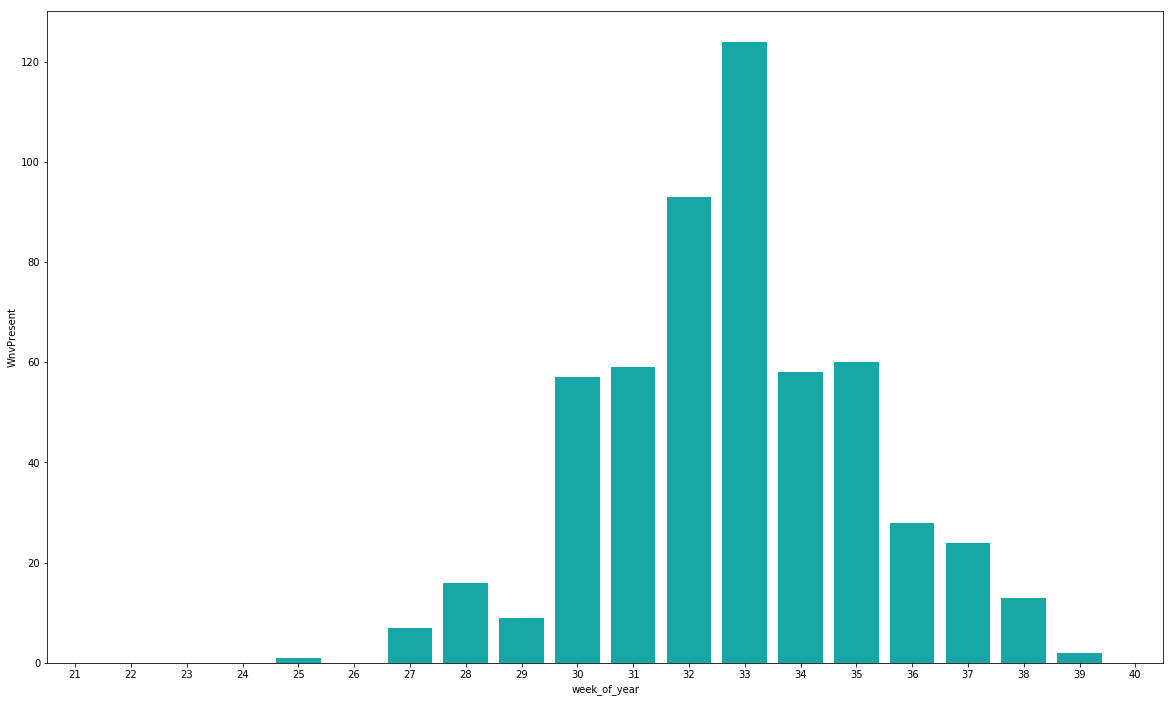

In [98]:
fig = plt.figure(figsize=(20,12))
sns.barplot(
            x = train.groupby('week_of_year').sum().index,
            y = train.groupby('week_of_year').sum()['WnvPresent'],
            color= 'c'
           )

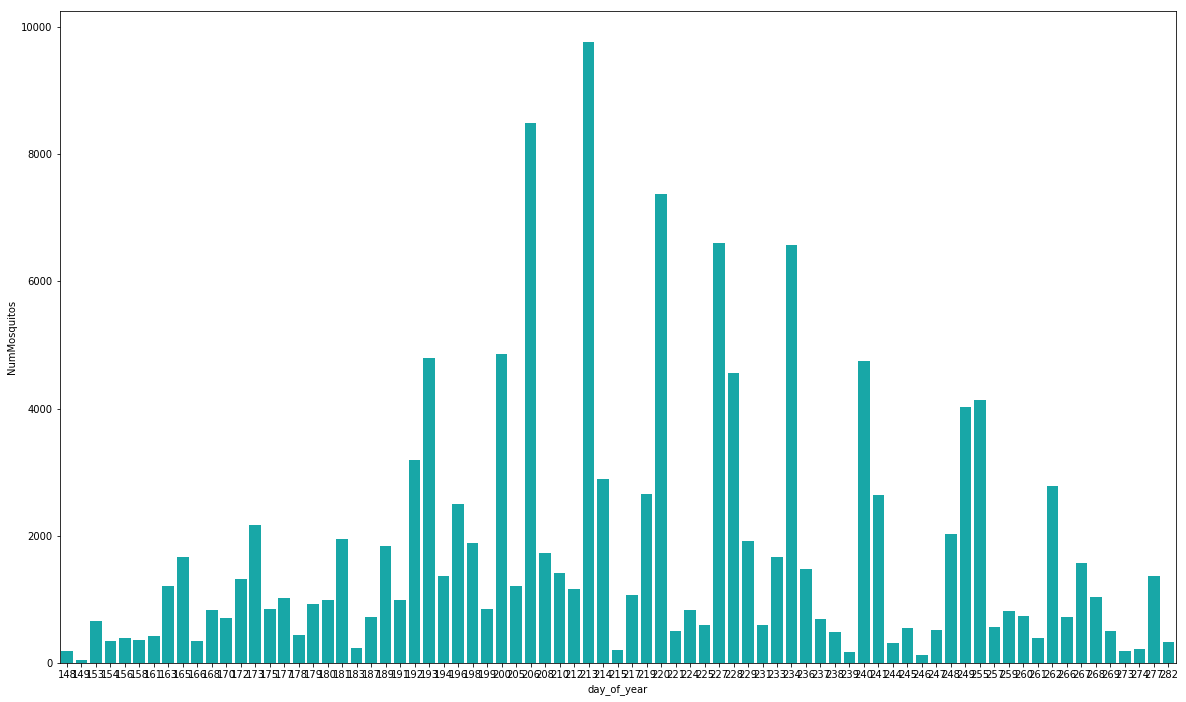

In [96]:
fig = plt.figure(figsize=(20,12))
sns.barplot(
            x = train.groupby('day_of_year').sum().index,
            y = train.groupby('day_of_year').sum()['NumMosquitos'],
            color = 'c'
           )


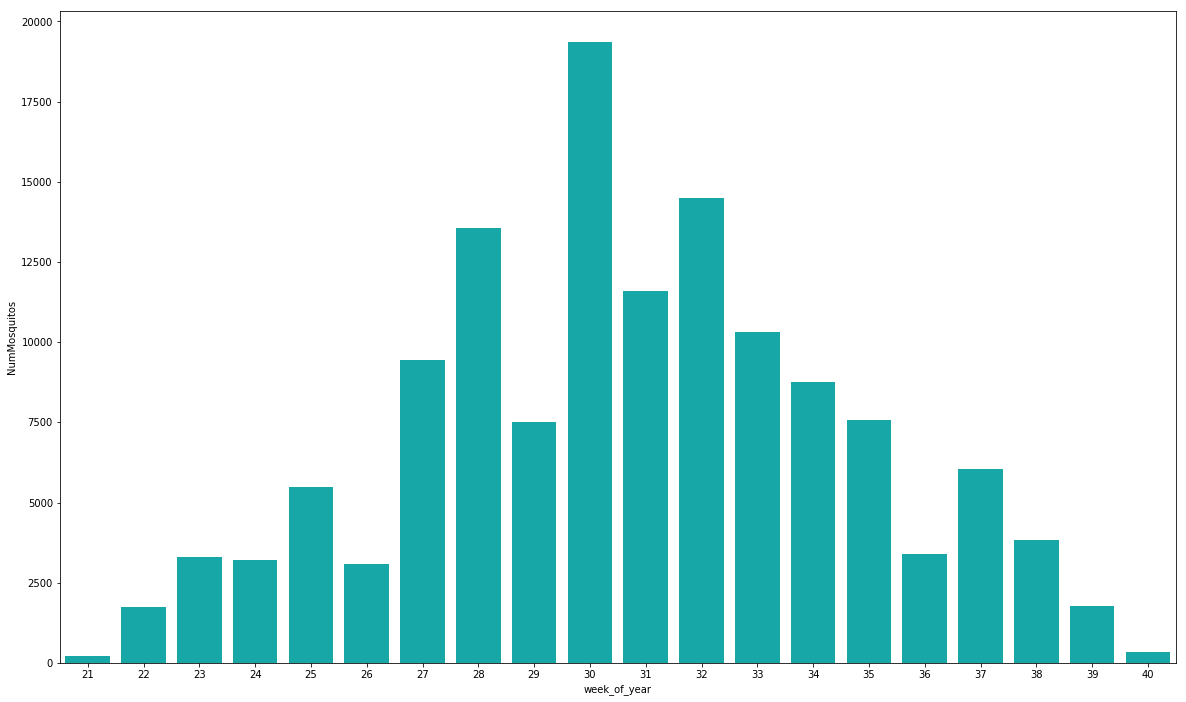

In [100]:
fig = plt.figure(figsize=(20,12))
sns.barplot(
            x = train.groupby('week_of_year').sum().index,
            y = train.groupby('week_of_year').sum()['NumMosquitos'],
            color = 'c'
           )


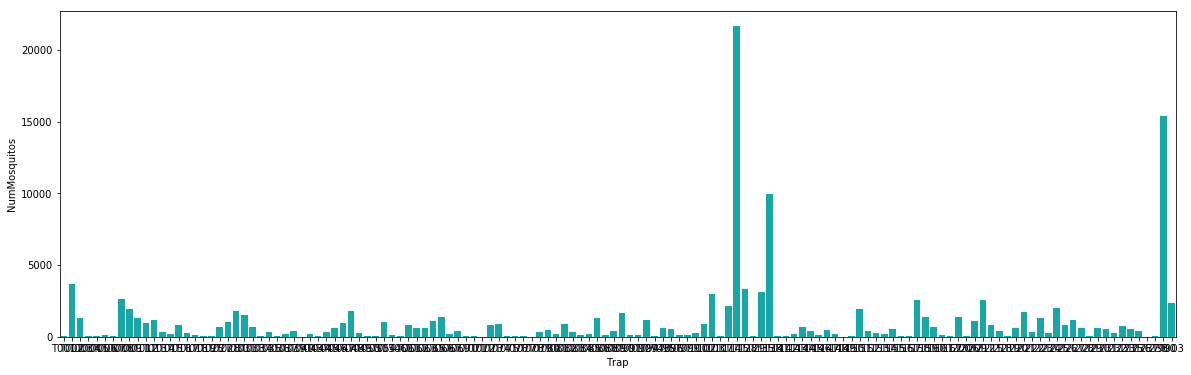

In [282]:
fig = plt.figure(figsize=(20,6))
sns.barplot(
            x = train.groupby('Trap').sum().index,
            y = train.groupby('Trap').sum()['NumMosquitos'],
            color = 'c'
           )

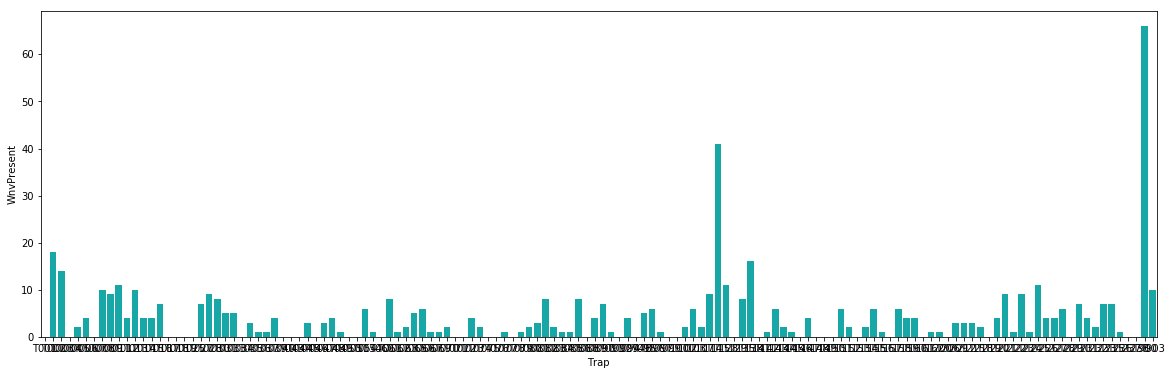

In [283]:
fig = plt.figure(figsize=(20,6))
sns.barplot(
            x = train.groupby('Trap').sum().index,
            y = train.groupby('Trap').sum()['WnvPresent'],
            color = 'c'
           )